In [1]:
pip install scikit-learn

     ---------------------------------------- 8.4/8.4 MB 1.2 MB/s eta 0:00:00
     ---------------------------------------- 42.5/42.5 MB 1.3 MB/s eta 0:00:00
     -------------------------------------- 298.0/298.0 kB 1.2 MB/s eta 0:00:00
     ---------------------------------------- 14.9/14.9 MB 1.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [1]:
# This function gives us the time value in miliseconds.
def current_milli_time():
    return round(time.time() * 1000)

# This function calculates the accuracy rate of a confusion matrix.
def calculate_AR(confusion_matrix):
    return (confusion_matrix[0][0] + confusion_matrix[1][1]) / (confusion_matrix[0][0] + confusion_matrix[0][1] + confusion_matrix[1][0] + confusion_matrix[1][1])

def print_values(algorithm:str, accuracy_rate:float, training_time:int):
    print(algorithm, "Accuracy rate", accuracy_rate, "Training time:", training_time)


# Obtaining dataset with malicious motes
flnme1 = "normal.csv"
# Obtaining dataset with normal motes
flnme2 = "attack.csv"

In [2]:
import pandas as pd
import time
from sklearn.model_selection import train_test_split # For splitting the data
from sklearn.preprocessing import StandardScaler # For normalizing the data
from sklearn.metrics import confusion_matrix # For creating the confurion matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

In [3]:
# We create the pandas datasets.
df1 = pd.read_csv(flnme1, sep=",")
df2 = pd.read_csv(flnme2, sep=",")

In [4]:
# Add a label column to each dataset
df1['Label'] = 0  # 0 for normal traffic
df2['Label'] = 1  # 1 for malicious traffic

In [5]:
# Remove double quotes from the entire DataFrame
df1 = df1.replace('"', '', regex=True)
# Remove double quotes from column names
df1.columns = df1.columns.str.strip('"')
df1 = df1.drop("No.", axis=1)

print(df1.head())


    Time                  Source Destination Protocol  Length   
0  0.000  fe80::212:7427:27:2727    ff02::1a   ICMPv6      64  \
1  0.009  fe80::212:7427:27:2727    ff02::1a   ICMPv6      64   
2  0.014  fe80::212:7427:27:2727    ff02::1a   ICMPv6      64   
3  0.149  fe80::212:7427:27:2727    ff02::1a   ICMPv6      64   
4  0.151  fe80::212:7427:27:2727    ff02::1a   ICMPv6      64   

                                           Info  Label  
0  RPL Control (DODAG Information Solicitation)      0  
1  RPL Control (DODAG Information Solicitation)      0  
2  RPL Control (DODAG Information Solicitation)      0  
3  RPL Control (DODAG Information Solicitation)      0  
4  RPL Control (DODAG Information Solicitation)      0  


In [6]:
#Making data meaningful
import numpy as np
# Converting Raw_Data to numpy array
np_Raw_Data = np.array(df1)

# Sorting data on 0 axis.(0 axis is the time values.)
# The columns 0: Time, 1: Source, 2:Destination, 3:Protocol, 4:Packet Length, 5:Info
np_Raw_Data = np_Raw_Data[np.argsort(np_Raw_Data[:, 0])]

In [7]:
# packetDurations list is used for calculating packet durations. With the while loop below, 
# we substracted two values np_Raw_Data[n][0] - np_Raw_Data[n - 1][0] and appended to the 
# packetDurations list.
packetDurations = []
counter = 0
while counter < len(np_Raw_Data):
    duration = 0
    if counter != 0 and counter + 1 <  len(np_Raw_Data):
        duration = np.float32(np_Raw_Data[counter][0])-np.float32(np_Raw_Data[counter - 1][0])
    packetDurations.append(duration) 
    counter +=  1

In [8]:
# We delete the first row of packetDurations
packetDurations = np.delete(packetDurations, 0, axis = 0)
# We delete the last row of np_Raw_Data
np_Raw_Data = np.delete(np_Raw_Data,len(np_Raw_Data)-1,axis = 0)

# We add  packetDurations column to the np_Raw_Data as 1st column.
# The columns 0: Time, 1:Packet Durations, 2: Source, 3:Destination, 4:Protocol, 5:Packet Length, 6:Info
np_Raw_Data = np.insert(np_Raw_Data, 1, packetDurations, axis = 1)

In [9]:
# source_unique_array variable contains unique values of source IP addresses.
source_unique_array = np.unique(np.array(df1.iloc[:,1:2].astype(str)))

# destination_unique_array variable contains unique values of destination IP addresses.
destination_unique_array = np.unique(np.array(df1.iloc[:,2:3].astype(str)))

# info_unique_array variable contains unique values of info colunm.
info_unique_array = np.unique(np.array(df1.iloc[:,5:6]))

# protocol_unique_array variable contains unique values of protocol column.
protocol_unique_array = np.unique(np.array(df1.iloc[:,3:4]))

# all_ip_addresses variable contains unique values of all IP addresses.
all_ip_addresses = np.concatenate((source_unique_array,destination_unique_array))
all_ip_addresses = np.unique(all_ip_addresses)

In [10]:
# ip_dict dictionary will hold the IPV6:IP Number key value pairs.
# example fe80::c30c:0:0:1 : 0
ip_dict = {}
# Here we used sklearn labelEncoder to give numbers to the ip addresses.
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
lb_all_ip_addresses = le.fit_transform(all_ip_addresses)

# with the for loop we added Ip address key value pairs.
cnt = 0
for x in all_ip_addresses:
    ip_dict[x] = lb_all_ip_addresses[cnt]
    cnt  += 1

# Sorting data on 0 axis.(0 axis is the time values.)
np_Raw_Data = np_Raw_Data[np.argsort(np_Raw_Data[:, 0])]

# duration variable is the last second of time column.
duration = np.floor(np.float32(np_Raw_Data[-1][0]))

In [11]:
# Variables that are used for calculating values.
counter = 0
currentSecond = 60.0
packetcount = {}
TotalPacketDuration = {}
TotalPacketLenght = {}
src_count = {}
dst_count = {}
src_duration = {}
dst_duration = {}
src_packet_lenght_sum = {}
dst_packet_lenght_sum = {}
DioCount = {}
DisCount = {}
DaoCount = {}
OtherMsg = {}
frame = []

In [12]:
#Create an empty pandas dataframe with the columns.

df1_meaningful = pd.DataFrame(columns = ['second','src', 'dst','packetcount','src_ratio', 'dst_ratio','src_duration_ratio', 'dst_duration_ratio','TotalPacketDuration','TotalPacketLenght','src_packet_ratio','dst_packet_ratio','DioCount','DisCount','DaoCount','OtherMsg','label'])

In [13]:
while counter < duration:  
    
    # one_second_frame variable holds rows for 1 second duration.
    one_second_frame = np_Raw_Data[np.where(np.logical_and(np_Raw_Data[:, 0] >= currentSecond, np_Raw_Data[:, 0] <= currentSecond + 1.0))]
    
    # if there is data in the one_second_frame, make calculations.
    if one_second_frame.size > 1:
        # clear all variables.
        packetcount.clear()
        TotalPacketDuration.clear()
        TotalPacketLenght.clear()
        DioCount.clear()
        DisCount.clear()
        DaoCount.clear()
        src_duration.clear()
        dst_duration.clear()
        totalpackets = 0
        frame_packet_length_sum = 0
        total_duration = 0.0
        src_packet_lenght_sum.clear()
        dst_packet_lenght_sum.clear()
        src_count.clear()
        dst_count.clear()
        
        # looping in each one_second_frame row
        for packet in one_second_frame:
            # IEEE 802.15.4 protocols or Ack messages do not have no IP addresses and they are null. We will not process this data.
            if not pd.isnull(packet[2]):
                # src_dst variable is string and it holds the value of source and destination value like fe80::c30c:0:0:3-fe80::c30c:0:0:1
                src = packet[2]
                dst = packet[3]
                src_dst  =  src + "-" + dst
                
                # packetcount dictionary holds the "src_dst : count" key value pairs. (How many packey counts do we have source to destination?)
                packetcount[src_dst]  =  1 if src_dst not in packetcount else packetcount[src_dst] + 1
                
                # TotalPacketDuration dictionary holds the "src_dst : duration" key value pairs. (It is the sum of all packet durations from source to destination in the 1-second frame.)
                TotalPacketDuration[src_dst] = packet[1] if src_dst not in TotalPacketDuration else TotalPacketDuration[src_dst] + packet[1]
                
                # TotalPacketLenght dictionary holds the "src_dst : length" key value pairs. (It is the sum of all packet lengths from source to destination in the 1-second frame.)
                TotalPacketLenght[src_dst] = packet[5] if src_dst not in TotalPacketLenght else TotalPacketLenght[src_dst] + packet[5]
                
                # src_count dictionary holds the "source : count" key value pairs. (How many source IP adress has in 1 second frame?)
                src_count[src] = 1 if src not in src_count else src_count[src] + 1
                
                # dst_count dictionary holds the "destination : count" key value pairs. (How many destination IP adress has in 1 second frame?)
                dst_count[dst] = 1 if dst not in dst_count else dst_count[dst] + 1
                
                # src_duration dictionary holds the "source : duration" key value pairs. (What is the duration of source IP address in 1 second frame?)
                src_duration[src] = packet[1] if src not in src_duration else src_duration[src] + packet[1]
                
                # dst_duration dictionary holds the "destination : duration" key value pairs. (What is the duration of destination IP address in 1 second frame?)
                dst_duration[dst] = packet[1] if dst not in dst_duration else dst_duration[dst] + packet[1]
                
                # total_duration will be used for calculating ratios in a one second frame
                total_duration += packet[1]
                
                # src_packet_lenght_sum dictionary holds "source : source_packet_length_sum" key value pairs.
                src_packet_lenght_sum[src] = packet[5] if src not in src_packet_lenght_sum else src_packet_lenght_sum[src] + packet[5]
                
                 # dst_packet_lenght_sum dictionary holds "destination : destination_packet_length_sum" key value pairs.
                dst_packet_lenght_sum[dst] = packet[5] if dst not in dst_packet_lenght_sum else dst_packet_lenght_sum[dst] + packet[5]
                
                # frame_packet_length_sum will be used for calculating ratios in a one second frame
                frame_packet_length_sum +=  packet[5]
                
                # totalpackets will be used for calculating ratios in a one second frame
                totalpackets +=  1
                
                # DIO, DIS, DAO messages counts.
                if packet[6]=="RPL Control (DODAG Information Object)":
                    DioCount[src_dst] = 1 if src_dst not in DioCount else DioCount[src_dst] + 1
                if packet[6]=="RPL Control (DODAG Information Solicitation)":
                    DisCount[src_dst] = 1 if src_dst not in DisCount else DisCount[src_dst] + 1
                if packet[6]=="RPL Control (Destination Advertisement Object)":
                    DaoCount[src_dst] = 1 if src_dst not in DaoCount else DaoCount[src_dst] + 1
                if ((packet[6]!="RPL Control (Destination Advertisement Object)") and (packet[6]!="RPL Control (DODAG Information Object)") and (packet[6]!="RPL Control (Destination Advertisement Object)")) :
                    OtherMsg[src_dst] = 1 if src_dst not in OtherMsg else OtherMsg[src_dst] + 1
       
        # this for loop calculates the ratios.
        for i in packetcount:
            if not i in DioCount:
                arr_diocount = 0
            else:
                arr_diocount = DioCount[i]
            if not i in DisCount:
                arr_discount = 0
            else:
                arr_discount = DisCount[i]
            if not i in DaoCount:
                arr_daocount = 0
            else:
                arr_daocount = DaoCount[i]
            if not i in OtherMsg:
                arr_orhermsg = 0
            else:
                arr_orhermsg = OtherMsg[i]
                
            # Splitting source and destination
            x = i.split("-")
            sourcee = x[0]
            destinatt = x[1]
            
            # calculating the source ratio in 1 second frame
            src_ratio = src_count[sourcee]/totalpackets
            
            # calculating the destination ratio in 1 second frame
            dst_ratio = dst_count[destinatt]/totalpackets
            
            # calculating the source duration ratio in 1 second frame
            src_duration_ratio = src_duration[sourcee]/total_duration
            
            # calculating the destination duration ratio in 1 second frame
            dst_duration_ratio = dst_duration[destinatt]/total_duration
            
            # calculating the source duration ratio in 1 second frame
            src_packet_ratio = src_packet_lenght_sum[sourcee]/frame_packet_length_sum
            
            # calculating the destination duration ratio in 1 second frame
            dst_packet_ratio = dst_packet_lenght_sum[destinatt]/frame_packet_length_sum
            
            #establishing an array for adding the calculations to the row of row dataframe.
            # the columns are: 
            # 'second',
            # 'src', 
            # 'dst',
            # 'packetcount',
            # 'src_ratio', 
            # 'dst_ratio',
            # 'src_duration_ratio', 
            # 'dst_duration_ratio',
            # 'TotalPacketDuration',
            # 'TotalPacketLenght',
            # 'src_packet_ratio',
            # 'dst_packet_ratio',
            # 'DioCount',
            # 'DisCount',
            # 'DaoCount',
            # 'OtherMsg',
            # 'label'
            array = np.array([
                np.single(currentSecond),
                ip_dict[sourcee],
                ip_dict[destinatt],
                int(packetcount[i]),
                np.single(src_ratio),
                np.single(dst_ratio),
                np.single(src_duration_ratio),
                np.single(dst_duration_ratio),
                TotalPacketDuration[i],
                TotalPacketLenght[i],
                np.single(src_packet_ratio),
                np.single(dst_packet_ratio),
                arr_diocount,
                arr_discount,
                arr_daocount,
                arr_orhermsg,
                0], dtype="object")
            # Create a new DataFrame from the array
            new_row = pd.DataFrame([array], columns=df1_meaningful.columns)
            # Concatenate the new row DataFrame with the existing DataFrame
            df1_meaningful = pd.concat([df1_meaningful, new_row], ignore_index=True)
            
    # increase second 1
    currentSecond += 1.0
    
    # increase counter 1
    counter +=  1
    
    # print data for observing the process.
    print(str(counter) + " of " + str(duration) + " of process is ok!!!")

1 of 2577.0 of process is ok!!!
2 of 2577.0 of process is ok!!!
3 of 2577.0 of process is ok!!!
4 of 2577.0 of process is ok!!!
5 of 2577.0 of process is ok!!!
6 of 2577.0 of process is ok!!!
7 of 2577.0 of process is ok!!!
8 of 2577.0 of process is ok!!!
9 of 2577.0 of process is ok!!!
10 of 2577.0 of process is ok!!!
11 of 2577.0 of process is ok!!!
12 of 2577.0 of process is ok!!!
13 of 2577.0 of process is ok!!!
14 of 2577.0 of process is ok!!!
15 of 2577.0 of process is ok!!!
16 of 2577.0 of process is ok!!!
17 of 2577.0 of process is ok!!!
18 of 2577.0 of process is ok!!!
19 of 2577.0 of process is ok!!!
20 of 2577.0 of process is ok!!!
21 of 2577.0 of process is ok!!!
22 of 2577.0 of process is ok!!!
23 of 2577.0 of process is ok!!!
24 of 2577.0 of process is ok!!!
25 of 2577.0 of process is ok!!!
26 of 2577.0 of process is ok!!!
27 of 2577.0 of process is ok!!!
28 of 2577.0 of process is ok!!!
29 of 2577.0 of process is ok!!!
30 of 2577.0 of process is ok!!!
31 of 2577.0 of pro

250 of 2577.0 of process is ok!!!
251 of 2577.0 of process is ok!!!
252 of 2577.0 of process is ok!!!
253 of 2577.0 of process is ok!!!
254 of 2577.0 of process is ok!!!
255 of 2577.0 of process is ok!!!
256 of 2577.0 of process is ok!!!
257 of 2577.0 of process is ok!!!
258 of 2577.0 of process is ok!!!
259 of 2577.0 of process is ok!!!
260 of 2577.0 of process is ok!!!
261 of 2577.0 of process is ok!!!
262 of 2577.0 of process is ok!!!
263 of 2577.0 of process is ok!!!
264 of 2577.0 of process is ok!!!
265 of 2577.0 of process is ok!!!
266 of 2577.0 of process is ok!!!
267 of 2577.0 of process is ok!!!
268 of 2577.0 of process is ok!!!
269 of 2577.0 of process is ok!!!
270 of 2577.0 of process is ok!!!
271 of 2577.0 of process is ok!!!
272 of 2577.0 of process is ok!!!
273 of 2577.0 of process is ok!!!
274 of 2577.0 of process is ok!!!
275 of 2577.0 of process is ok!!!
276 of 2577.0 of process is ok!!!
277 of 2577.0 of process is ok!!!
278 of 2577.0 of process is ok!!!
279 of 2577.0 

503 of 2577.0 of process is ok!!!
504 of 2577.0 of process is ok!!!
505 of 2577.0 of process is ok!!!
506 of 2577.0 of process is ok!!!
507 of 2577.0 of process is ok!!!
508 of 2577.0 of process is ok!!!
509 of 2577.0 of process is ok!!!
510 of 2577.0 of process is ok!!!
511 of 2577.0 of process is ok!!!
512 of 2577.0 of process is ok!!!
513 of 2577.0 of process is ok!!!
514 of 2577.0 of process is ok!!!
515 of 2577.0 of process is ok!!!
516 of 2577.0 of process is ok!!!
517 of 2577.0 of process is ok!!!
518 of 2577.0 of process is ok!!!
519 of 2577.0 of process is ok!!!
520 of 2577.0 of process is ok!!!
521 of 2577.0 of process is ok!!!
522 of 2577.0 of process is ok!!!
523 of 2577.0 of process is ok!!!
524 of 2577.0 of process is ok!!!
525 of 2577.0 of process is ok!!!
526 of 2577.0 of process is ok!!!
527 of 2577.0 of process is ok!!!
528 of 2577.0 of process is ok!!!
529 of 2577.0 of process is ok!!!
530 of 2577.0 of process is ok!!!
531 of 2577.0 of process is ok!!!
532 of 2577.0 

754 of 2577.0 of process is ok!!!
755 of 2577.0 of process is ok!!!
756 of 2577.0 of process is ok!!!
757 of 2577.0 of process is ok!!!
758 of 2577.0 of process is ok!!!
759 of 2577.0 of process is ok!!!
760 of 2577.0 of process is ok!!!
761 of 2577.0 of process is ok!!!
762 of 2577.0 of process is ok!!!
763 of 2577.0 of process is ok!!!
764 of 2577.0 of process is ok!!!
765 of 2577.0 of process is ok!!!
766 of 2577.0 of process is ok!!!
767 of 2577.0 of process is ok!!!
768 of 2577.0 of process is ok!!!
769 of 2577.0 of process is ok!!!
770 of 2577.0 of process is ok!!!
771 of 2577.0 of process is ok!!!
772 of 2577.0 of process is ok!!!
773 of 2577.0 of process is ok!!!
774 of 2577.0 of process is ok!!!
775 of 2577.0 of process is ok!!!
776 of 2577.0 of process is ok!!!
777 of 2577.0 of process is ok!!!
778 of 2577.0 of process is ok!!!
779 of 2577.0 of process is ok!!!
780 of 2577.0 of process is ok!!!
781 of 2577.0 of process is ok!!!
782 of 2577.0 of process is ok!!!
783 of 2577.0 

1010 of 2577.0 of process is ok!!!
1011 of 2577.0 of process is ok!!!
1012 of 2577.0 of process is ok!!!
1013 of 2577.0 of process is ok!!!
1014 of 2577.0 of process is ok!!!
1015 of 2577.0 of process is ok!!!
1016 of 2577.0 of process is ok!!!
1017 of 2577.0 of process is ok!!!
1018 of 2577.0 of process is ok!!!
1019 of 2577.0 of process is ok!!!
1020 of 2577.0 of process is ok!!!
1021 of 2577.0 of process is ok!!!
1022 of 2577.0 of process is ok!!!
1023 of 2577.0 of process is ok!!!
1024 of 2577.0 of process is ok!!!
1025 of 2577.0 of process is ok!!!
1026 of 2577.0 of process is ok!!!
1027 of 2577.0 of process is ok!!!
1028 of 2577.0 of process is ok!!!
1029 of 2577.0 of process is ok!!!
1030 of 2577.0 of process is ok!!!
1031 of 2577.0 of process is ok!!!
1032 of 2577.0 of process is ok!!!
1033 of 2577.0 of process is ok!!!
1034 of 2577.0 of process is ok!!!
1035 of 2577.0 of process is ok!!!
1036 of 2577.0 of process is ok!!!
1037 of 2577.0 of process is ok!!!
1038 of 2577.0 of pr

1247 of 2577.0 of process is ok!!!
1248 of 2577.0 of process is ok!!!
1249 of 2577.0 of process is ok!!!
1250 of 2577.0 of process is ok!!!
1251 of 2577.0 of process is ok!!!
1252 of 2577.0 of process is ok!!!
1253 of 2577.0 of process is ok!!!
1254 of 2577.0 of process is ok!!!
1255 of 2577.0 of process is ok!!!
1256 of 2577.0 of process is ok!!!
1257 of 2577.0 of process is ok!!!
1258 of 2577.0 of process is ok!!!
1259 of 2577.0 of process is ok!!!
1260 of 2577.0 of process is ok!!!
1261 of 2577.0 of process is ok!!!
1262 of 2577.0 of process is ok!!!
1263 of 2577.0 of process is ok!!!
1264 of 2577.0 of process is ok!!!
1265 of 2577.0 of process is ok!!!
1266 of 2577.0 of process is ok!!!
1267 of 2577.0 of process is ok!!!
1268 of 2577.0 of process is ok!!!
1269 of 2577.0 of process is ok!!!
1270 of 2577.0 of process is ok!!!
1271 of 2577.0 of process is ok!!!
1272 of 2577.0 of process is ok!!!
1273 of 2577.0 of process is ok!!!
1274 of 2577.0 of process is ok!!!
1275 of 2577.0 of pr

1501 of 2577.0 of process is ok!!!
1502 of 2577.0 of process is ok!!!
1503 of 2577.0 of process is ok!!!
1504 of 2577.0 of process is ok!!!
1505 of 2577.0 of process is ok!!!
1506 of 2577.0 of process is ok!!!
1507 of 2577.0 of process is ok!!!
1508 of 2577.0 of process is ok!!!
1509 of 2577.0 of process is ok!!!
1510 of 2577.0 of process is ok!!!
1511 of 2577.0 of process is ok!!!
1512 of 2577.0 of process is ok!!!
1513 of 2577.0 of process is ok!!!
1514 of 2577.0 of process is ok!!!
1515 of 2577.0 of process is ok!!!
1516 of 2577.0 of process is ok!!!
1517 of 2577.0 of process is ok!!!
1518 of 2577.0 of process is ok!!!
1519 of 2577.0 of process is ok!!!
1520 of 2577.0 of process is ok!!!
1521 of 2577.0 of process is ok!!!
1522 of 2577.0 of process is ok!!!
1523 of 2577.0 of process is ok!!!
1524 of 2577.0 of process is ok!!!
1525 of 2577.0 of process is ok!!!
1526 of 2577.0 of process is ok!!!
1527 of 2577.0 of process is ok!!!
1528 of 2577.0 of process is ok!!!
1529 of 2577.0 of pr

1750 of 2577.0 of process is ok!!!
1751 of 2577.0 of process is ok!!!
1752 of 2577.0 of process is ok!!!
1753 of 2577.0 of process is ok!!!
1754 of 2577.0 of process is ok!!!
1755 of 2577.0 of process is ok!!!
1756 of 2577.0 of process is ok!!!
1757 of 2577.0 of process is ok!!!
1758 of 2577.0 of process is ok!!!
1759 of 2577.0 of process is ok!!!
1760 of 2577.0 of process is ok!!!
1761 of 2577.0 of process is ok!!!
1762 of 2577.0 of process is ok!!!
1763 of 2577.0 of process is ok!!!
1764 of 2577.0 of process is ok!!!
1765 of 2577.0 of process is ok!!!
1766 of 2577.0 of process is ok!!!
1767 of 2577.0 of process is ok!!!
1768 of 2577.0 of process is ok!!!
1769 of 2577.0 of process is ok!!!
1770 of 2577.0 of process is ok!!!
1771 of 2577.0 of process is ok!!!
1772 of 2577.0 of process is ok!!!
1773 of 2577.0 of process is ok!!!
1774 of 2577.0 of process is ok!!!
1775 of 2577.0 of process is ok!!!
1776 of 2577.0 of process is ok!!!
1777 of 2577.0 of process is ok!!!
1778 of 2577.0 of pr

2003 of 2577.0 of process is ok!!!
2004 of 2577.0 of process is ok!!!
2005 of 2577.0 of process is ok!!!
2006 of 2577.0 of process is ok!!!
2007 of 2577.0 of process is ok!!!
2008 of 2577.0 of process is ok!!!
2009 of 2577.0 of process is ok!!!
2010 of 2577.0 of process is ok!!!
2011 of 2577.0 of process is ok!!!
2012 of 2577.0 of process is ok!!!
2013 of 2577.0 of process is ok!!!
2014 of 2577.0 of process is ok!!!
2015 of 2577.0 of process is ok!!!
2016 of 2577.0 of process is ok!!!
2017 of 2577.0 of process is ok!!!
2018 of 2577.0 of process is ok!!!
2019 of 2577.0 of process is ok!!!
2020 of 2577.0 of process is ok!!!
2021 of 2577.0 of process is ok!!!
2022 of 2577.0 of process is ok!!!
2023 of 2577.0 of process is ok!!!
2024 of 2577.0 of process is ok!!!
2025 of 2577.0 of process is ok!!!
2026 of 2577.0 of process is ok!!!
2027 of 2577.0 of process is ok!!!
2028 of 2577.0 of process is ok!!!
2029 of 2577.0 of process is ok!!!
2030 of 2577.0 of process is ok!!!
2031 of 2577.0 of pr

2245 of 2577.0 of process is ok!!!
2246 of 2577.0 of process is ok!!!
2247 of 2577.0 of process is ok!!!
2248 of 2577.0 of process is ok!!!
2249 of 2577.0 of process is ok!!!
2250 of 2577.0 of process is ok!!!
2251 of 2577.0 of process is ok!!!
2252 of 2577.0 of process is ok!!!
2253 of 2577.0 of process is ok!!!
2254 of 2577.0 of process is ok!!!
2255 of 2577.0 of process is ok!!!
2256 of 2577.0 of process is ok!!!
2257 of 2577.0 of process is ok!!!
2258 of 2577.0 of process is ok!!!
2259 of 2577.0 of process is ok!!!
2260 of 2577.0 of process is ok!!!
2261 of 2577.0 of process is ok!!!
2262 of 2577.0 of process is ok!!!
2263 of 2577.0 of process is ok!!!
2264 of 2577.0 of process is ok!!!
2265 of 2577.0 of process is ok!!!
2266 of 2577.0 of process is ok!!!
2267 of 2577.0 of process is ok!!!
2268 of 2577.0 of process is ok!!!
2269 of 2577.0 of process is ok!!!
2270 of 2577.0 of process is ok!!!
2271 of 2577.0 of process is ok!!!
2272 of 2577.0 of process is ok!!!
2273 of 2577.0 of pr

2494 of 2577.0 of process is ok!!!
2495 of 2577.0 of process is ok!!!
2496 of 2577.0 of process is ok!!!
2497 of 2577.0 of process is ok!!!
2498 of 2577.0 of process is ok!!!
2499 of 2577.0 of process is ok!!!
2500 of 2577.0 of process is ok!!!
2501 of 2577.0 of process is ok!!!
2502 of 2577.0 of process is ok!!!
2503 of 2577.0 of process is ok!!!
2504 of 2577.0 of process is ok!!!
2505 of 2577.0 of process is ok!!!
2506 of 2577.0 of process is ok!!!
2507 of 2577.0 of process is ok!!!
2508 of 2577.0 of process is ok!!!
2509 of 2577.0 of process is ok!!!
2510 of 2577.0 of process is ok!!!
2511 of 2577.0 of process is ok!!!
2512 of 2577.0 of process is ok!!!
2513 of 2577.0 of process is ok!!!
2514 of 2577.0 of process is ok!!!
2515 of 2577.0 of process is ok!!!
2516 of 2577.0 of process is ok!!!
2517 of 2577.0 of process is ok!!!
2518 of 2577.0 of process is ok!!!
2519 of 2577.0 of process is ok!!!
2520 of 2577.0 of process is ok!!!
2521 of 2577.0 of process is ok!!!
2522 of 2577.0 of pr

In [15]:
print(df1_meaningful.head())
df1_meaningful.to_csv('mNormal.csv', index=False)

   second  src  dst packetcount  src_ratio  dst_ratio  src_duration_ratio   
0    60.0  101  103          18   0.473684   0.315789            0.701806  \
1    60.0  100  131           3   0.052632   0.473684            0.001003   
2    60.0  126   83          12   0.438596   0.210526            0.295184   
3    60.0  119  131           2   0.035088   0.473684            0.002007   
4    60.0  126  131          13   0.438596   0.473684            0.295184   

   dst_duration_ratio  TotalPacketDuration TotalPacketLenght   
0            0.267068             0.265999              1368  \
1            0.631525             0.000999               192   
2            0.101408             0.101002               912   
3            0.631525             0.001999               128   
4            0.631525             0.193001              1261   

   src_packet_ratio  dst_packet_ratio DioCount DisCount DaoCount OtherMsg   
0          0.473384          0.288973        0        0       18        0  

In [5]:
#do the same with df2
# Remove double quotes from the entire DataFrame
df2 = df2.replace('"', '', regex=True)
# Remove double quotes from column names
df2.columns = df2.columns.str.strip('"')
df2 = df2.drop("No.", axis=1)

In [7]:
# Converting Raw_Data to numpy array
import numpy as np
np_Raw_Data = np.array(df2)

# Sorting data on 0 axis.(0 axis is the time values.)
# The columns 0: Time, 1: Source, 2:Destination, 3:Protocol, 4:Packet Length, 5:Info
np_Raw_Data = np_Raw_Data[np.argsort(np_Raw_Data[:, 0])]

In [8]:
# packetDurations list is used for calculating packet durations. With the while loop below, 
# we substracted two values np_Raw_Data[n][0] - np_Raw_Data[n - 1][0] and appended to the 
# packetDurations list.
packetDurations = []
counter = 0
while counter < len(np_Raw_Data):
    duration = 0
    if counter != 0 and counter + 1 <  len(np_Raw_Data):
        duration = np.float32(np_Raw_Data[counter][0])-np.float32(np_Raw_Data[counter - 1][0])
    packetDurations.append(duration) 
    counter +=  1

In [9]:
# We delete the first row of packetDurations
packetDurations = np.delete(packetDurations, 0, axis = 0)
# We delete the last row of np_Raw_Data
np_Raw_Data = np.delete(np_Raw_Data,len(np_Raw_Data)-1,axis = 0)

# We add  packetDurations column to the np_Raw_Data as 1st column.
# The columns 0: Time, 1:Packet Durations, 2: Source, 3:Destination, 4:Protocol, 5:Packet Length, 6:Info
np_Raw_Data = np.insert(np_Raw_Data, 1, packetDurations, axis = 1)

In [10]:
# source_unique_array variable contains unique values of source IP addresses.
source_unique_array = np.unique(np.array(df2.iloc[:,1:2].astype(str)))

# destination_unique_array variable contains unique values of destination IP addresses.
destination_unique_array = np.unique(np.array(df2.iloc[:,2:3].astype(str)))

# info_unique_array variable contains unique values of info colunm.
info_unique_array = np.unique(np.array(df2.iloc[:,5:6]))

# protocol_unique_array variable contains unique values of protocol column.
protocol_unique_array = np.unique(np.array(df2.iloc[:,3:4]))

# all_ip_addresses variable contains unique values of all IP addresses.
all_ip_addresses = np.concatenate((source_unique_array,destination_unique_array))
all_ip_addresses = np.unique(all_ip_addresses)

In [11]:
# ip_dict dictionary will hold the IPV6:IP Number key value pairs.
# example fe80::c30c:0:0:1 : 0
ip_dict = {}
# Here we used sklearn labelEncoder to give numbers to the ip addresses.
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
lb_all_ip_addresses = le.fit_transform(all_ip_addresses)

# with the for loop we added Ip address key value pairs.
cnt = 0
for x in all_ip_addresses:
    ip_dict[x] = lb_all_ip_addresses[cnt]
    cnt  += 1

# Sorting data on 0 axis.(0 axis is the time values.)
np_Raw_Data = np_Raw_Data[np.argsort(np_Raw_Data[:, 0])]

# duration variable is the last second of time column.
duration = np.floor(np.float32(np_Raw_Data[-1][0]))

In [12]:
# Variables that are used for calculating values.
counter = 0
currentSecond = 60.0
packetcount = {}
TotalPacketDuration = {}
TotalPacketLenght = {}
src_count = {}
dst_count = {}
src_duration = {}
dst_duration = {}
src_packet_lenght_sum = {}
dst_packet_lenght_sum = {}
DioCount = {}
DisCount = {}
DaoCount = {}
OtherMsg = {}
frame = []

In [13]:
#Create an empty pandas dataframe with the columns.

df2_meaningful = pd.DataFrame(columns = ['second','src', 'dst','packetcount','src_ratio', 'dst_ratio','src_duration_ratio', 'dst_duration_ratio','TotalPacketDuration','TotalPacketLenght','src_packet_ratio','dst_packet_ratio','DioCount','DisCount','DaoCount','OtherMsg','label'])

In [14]:
while counter < duration:  
    
    # one_second_frame variable holds rows for 1 second duration.
    one_second_frame = np_Raw_Data[np.where(np.logical_and(np_Raw_Data[:, 0] >= currentSecond, np_Raw_Data[:, 0] <= currentSecond + 1.0))]
    
    # if there is data in the one_second_frame, make calculations.
    if one_second_frame.size > 1:
        # clear all variables.
        packetcount.clear()
        TotalPacketDuration.clear()
        TotalPacketLenght.clear()
        DioCount.clear()
        DisCount.clear()
        DaoCount.clear()
        src_duration.clear()
        dst_duration.clear()
        totalpackets = 0
        frame_packet_length_sum = 0
        total_duration = 0.0
        src_packet_lenght_sum.clear()
        dst_packet_lenght_sum.clear()
        src_count.clear()
        dst_count.clear()
        
        # looping in each one_second_frame row
        for packet in one_second_frame:
            # IEEE 802.15.4 protocols or Ack messages do not have no IP addresses and they are null. We will not process this data.
            if not pd.isnull(packet[2]):
                # src_dst variable is string and it holds the value of source and destination value like fe80::c30c:0:0:3-fe80::c30c:0:0:1
                src = packet[2]
                dst = packet[3]
                src_dst  =  src + "-" + dst
                
                # packetcount dictionary holds the "src_dst : count" key value pairs. (How many packey counts do we have source to destination?)
                packetcount[src_dst]  =  1 if src_dst not in packetcount else packetcount[src_dst] + 1
                
                # TotalPacketDuration dictionary holds the "src_dst : duration" key value pairs. (It is the sum of all packet durations from source to destination in the 1-second frame.)
                TotalPacketDuration[src_dst] = packet[1] if src_dst not in TotalPacketDuration else TotalPacketDuration[src_dst] + packet[1]
                
                # TotalPacketLenght dictionary holds the "src_dst : length" key value pairs. (It is the sum of all packet lengths from source to destination in the 1-second frame.)
                TotalPacketLenght[src_dst] = packet[5] if src_dst not in TotalPacketLenght else TotalPacketLenght[src_dst] + packet[5]
                
                # src_count dictionary holds the "source : count" key value pairs. (How many source IP adress has in 1 second frame?)
                src_count[src] = 1 if src not in src_count else src_count[src] + 1
                
                # dst_count dictionary holds the "destination : count" key value pairs. (How many destination IP adress has in 1 second frame?)
                dst_count[dst] = 1 if dst not in dst_count else dst_count[dst] + 1
                
                # src_duration dictionary holds the "source : duration" key value pairs. (What is the duration of source IP address in 1 second frame?)
                src_duration[src] = packet[1] if src not in src_duration else src_duration[src] + packet[1]
                
                # dst_duration dictionary holds the "destination : duration" key value pairs. (What is the duration of destination IP address in 1 second frame?)
                dst_duration[dst] = packet[1] if dst not in dst_duration else dst_duration[dst] + packet[1]
                
                # total_duration will be used for calculating ratios in a one second frame
                total_duration += packet[1]
                
                # src_packet_lenght_sum dictionary holds "source : source_packet_length_sum" key value pairs.
                src_packet_lenght_sum[src] = packet[5] if src not in src_packet_lenght_sum else src_packet_lenght_sum[src] + packet[5]
                
                 # dst_packet_lenght_sum dictionary holds "destination : destination_packet_length_sum" key value pairs.
                dst_packet_lenght_sum[dst] = packet[5] if dst not in dst_packet_lenght_sum else dst_packet_lenght_sum[dst] + packet[5]
                
                # frame_packet_length_sum will be used for calculating ratios in a one second frame
                frame_packet_length_sum +=  packet[5]
                
                # totalpackets will be used for calculating ratios in a one second frame
                totalpackets +=  1
                
                # DIO, DIS, DAO messages counts.
                if packet[6]=="RPL Control (DODAG Information Object)":
                    DioCount[src_dst] = 1 if src_dst not in DioCount else DioCount[src_dst] + 1
                if packet[6]=="RPL Control (DODAG Information Solicitation)":
                    DisCount[src_dst] = 1 if src_dst not in DisCount else DisCount[src_dst] + 1
                if packet[6]=="RPL Control (Destination Advertisement Object)":
                    DaoCount[src_dst] = 1 if src_dst not in DaoCount else DaoCount[src_dst] + 1
                if ((packet[6]!="RPL Control (Destination Advertisement Object)") and (packet[6]!="RPL Control (DODAG Information Object)") and (packet[6]!="RPL Control (Destination Advertisement Object)")) :
                    OtherMsg[src_dst] = 1 if src_dst not in OtherMsg else OtherMsg[src_dst] + 1
       
        # this for loop calculates the ratios.
        for i in packetcount:
            if not i in DioCount:
                arr_diocount = 0
            else:
                arr_diocount = DioCount[i]
            if not i in DisCount:
                arr_discount = 0
            else:
                arr_discount = DisCount[i]
            if not i in DaoCount:
                arr_daocount = 0
            else:
                arr_daocount = DaoCount[i]
            if not i in OtherMsg:
                arr_orhermsg = 0
            else:
                arr_orhermsg = OtherMsg[i]
                
            # Splitting source and destination
            x = i.split("-")
            sourcee = x[0]
            destinatt = x[1]
            
            # calculating the source ratio in 1 second frame
            src_ratio = src_count[sourcee]/totalpackets
            
            # calculating the destination ratio in 1 second frame
            dst_ratio = dst_count[destinatt]/totalpackets
            
            # calculating the source duration ratio in 1 second frame
            src_duration_ratio = src_duration[sourcee]/total_duration
            
            # calculating the destination duration ratio in 1 second frame
            dst_duration_ratio = dst_duration[destinatt]/total_duration
            
            # calculating the source duration ratio in 1 second frame
            src_packet_ratio = src_packet_lenght_sum[sourcee]/frame_packet_length_sum
            
            # calculating the destination duration ratio in 1 second frame
            dst_packet_ratio = dst_packet_lenght_sum[destinatt]/frame_packet_length_sum
            
            #establishing an array for adding the calculations to the row of row dataframe.
            # the columns are: 
            # 'second',
            # 'src', 
            # 'dst',
            # 'packetcount',
            # 'src_ratio', 
            # 'dst_ratio',
            # 'src_duration_ratio', 
            # 'dst_duration_ratio',
            # 'TotalPacketDuration',
            # 'TotalPacketLenght',
            # 'src_packet_ratio',
            # 'dst_packet_ratio',
            # 'DioCount',
            # 'DisCount',
            # 'DaoCount',
            # 'OtherMsg',
            # 'label'
            array = np.array([
                np.single(currentSecond),
                ip_dict[sourcee],
                ip_dict[destinatt],
                int(packetcount[i]),
                np.single(src_ratio),
                np.single(dst_ratio),
                np.single(src_duration_ratio),
                np.single(dst_duration_ratio),
                TotalPacketDuration[i],
                TotalPacketLenght[i],
                np.single(src_packet_ratio),
                np.single(dst_packet_ratio),
                arr_diocount,
                arr_discount,
                arr_daocount,
                arr_orhermsg,
                1], dtype="object")
            # Create a new DataFrame from the array
            new_row = pd.DataFrame([array], columns=df2_meaningful.columns)
            # Concatenate the new row DataFrame with the existing DataFrame
            df2_meaningful = pd.concat([df2_meaningful, new_row], ignore_index=True)
            
    # increase second 1
    currentSecond += 1.0
    
    # increase counter 1
    counter +=  1
    
    # print data for observing the process.
    print(str(counter) + " of " + str(duration) + " of process is ok!!!")

1 of 1665.0 of process is ok!!!
2 of 1665.0 of process is ok!!!
3 of 1665.0 of process is ok!!!
4 of 1665.0 of process is ok!!!
5 of 1665.0 of process is ok!!!
6 of 1665.0 of process is ok!!!
7 of 1665.0 of process is ok!!!
8 of 1665.0 of process is ok!!!
9 of 1665.0 of process is ok!!!
10 of 1665.0 of process is ok!!!
11 of 1665.0 of process is ok!!!
12 of 1665.0 of process is ok!!!
13 of 1665.0 of process is ok!!!
14 of 1665.0 of process is ok!!!
15 of 1665.0 of process is ok!!!
16 of 1665.0 of process is ok!!!
17 of 1665.0 of process is ok!!!
18 of 1665.0 of process is ok!!!
19 of 1665.0 of process is ok!!!
20 of 1665.0 of process is ok!!!
21 of 1665.0 of process is ok!!!
22 of 1665.0 of process is ok!!!
23 of 1665.0 of process is ok!!!
24 of 1665.0 of process is ok!!!
25 of 1665.0 of process is ok!!!
26 of 1665.0 of process is ok!!!
27 of 1665.0 of process is ok!!!
28 of 1665.0 of process is ok!!!
29 of 1665.0 of process is ok!!!
30 of 1665.0 of process is ok!!!
31 of 1665.0 of pro

249 of 1665.0 of process is ok!!!
250 of 1665.0 of process is ok!!!
251 of 1665.0 of process is ok!!!
252 of 1665.0 of process is ok!!!
253 of 1665.0 of process is ok!!!
254 of 1665.0 of process is ok!!!
255 of 1665.0 of process is ok!!!
256 of 1665.0 of process is ok!!!
257 of 1665.0 of process is ok!!!
258 of 1665.0 of process is ok!!!
259 of 1665.0 of process is ok!!!
260 of 1665.0 of process is ok!!!
261 of 1665.0 of process is ok!!!
262 of 1665.0 of process is ok!!!
263 of 1665.0 of process is ok!!!
264 of 1665.0 of process is ok!!!
265 of 1665.0 of process is ok!!!
266 of 1665.0 of process is ok!!!
267 of 1665.0 of process is ok!!!
268 of 1665.0 of process is ok!!!
269 of 1665.0 of process is ok!!!
270 of 1665.0 of process is ok!!!
271 of 1665.0 of process is ok!!!
272 of 1665.0 of process is ok!!!
273 of 1665.0 of process is ok!!!
274 of 1665.0 of process is ok!!!
275 of 1665.0 of process is ok!!!
276 of 1665.0 of process is ok!!!
277 of 1665.0 of process is ok!!!
278 of 1665.0 

500 of 1665.0 of process is ok!!!
501 of 1665.0 of process is ok!!!
502 of 1665.0 of process is ok!!!
503 of 1665.0 of process is ok!!!
504 of 1665.0 of process is ok!!!
505 of 1665.0 of process is ok!!!
506 of 1665.0 of process is ok!!!
507 of 1665.0 of process is ok!!!
508 of 1665.0 of process is ok!!!
509 of 1665.0 of process is ok!!!
510 of 1665.0 of process is ok!!!
511 of 1665.0 of process is ok!!!
512 of 1665.0 of process is ok!!!
513 of 1665.0 of process is ok!!!
514 of 1665.0 of process is ok!!!
515 of 1665.0 of process is ok!!!
516 of 1665.0 of process is ok!!!
517 of 1665.0 of process is ok!!!
518 of 1665.0 of process is ok!!!
519 of 1665.0 of process is ok!!!
520 of 1665.0 of process is ok!!!
521 of 1665.0 of process is ok!!!
522 of 1665.0 of process is ok!!!
523 of 1665.0 of process is ok!!!
524 of 1665.0 of process is ok!!!
525 of 1665.0 of process is ok!!!
526 of 1665.0 of process is ok!!!
527 of 1665.0 of process is ok!!!
528 of 1665.0 of process is ok!!!
529 of 1665.0 

756 of 1665.0 of process is ok!!!
757 of 1665.0 of process is ok!!!
758 of 1665.0 of process is ok!!!
759 of 1665.0 of process is ok!!!
760 of 1665.0 of process is ok!!!
761 of 1665.0 of process is ok!!!
762 of 1665.0 of process is ok!!!
763 of 1665.0 of process is ok!!!
764 of 1665.0 of process is ok!!!
765 of 1665.0 of process is ok!!!
766 of 1665.0 of process is ok!!!
767 of 1665.0 of process is ok!!!
768 of 1665.0 of process is ok!!!
769 of 1665.0 of process is ok!!!
770 of 1665.0 of process is ok!!!
771 of 1665.0 of process is ok!!!
772 of 1665.0 of process is ok!!!
773 of 1665.0 of process is ok!!!
774 of 1665.0 of process is ok!!!
775 of 1665.0 of process is ok!!!
776 of 1665.0 of process is ok!!!
777 of 1665.0 of process is ok!!!
778 of 1665.0 of process is ok!!!
779 of 1665.0 of process is ok!!!
780 of 1665.0 of process is ok!!!
781 of 1665.0 of process is ok!!!
782 of 1665.0 of process is ok!!!
783 of 1665.0 of process is ok!!!
784 of 1665.0 of process is ok!!!
785 of 1665.0 

1003 of 1665.0 of process is ok!!!
1004 of 1665.0 of process is ok!!!
1005 of 1665.0 of process is ok!!!
1006 of 1665.0 of process is ok!!!
1007 of 1665.0 of process is ok!!!
1008 of 1665.0 of process is ok!!!
1009 of 1665.0 of process is ok!!!
1010 of 1665.0 of process is ok!!!
1011 of 1665.0 of process is ok!!!
1012 of 1665.0 of process is ok!!!
1013 of 1665.0 of process is ok!!!
1014 of 1665.0 of process is ok!!!
1015 of 1665.0 of process is ok!!!
1016 of 1665.0 of process is ok!!!
1017 of 1665.0 of process is ok!!!
1018 of 1665.0 of process is ok!!!
1019 of 1665.0 of process is ok!!!
1020 of 1665.0 of process is ok!!!
1021 of 1665.0 of process is ok!!!
1022 of 1665.0 of process is ok!!!
1023 of 1665.0 of process is ok!!!
1024 of 1665.0 of process is ok!!!
1025 of 1665.0 of process is ok!!!
1026 of 1665.0 of process is ok!!!
1027 of 1665.0 of process is ok!!!
1028 of 1665.0 of process is ok!!!
1029 of 1665.0 of process is ok!!!
1030 of 1665.0 of process is ok!!!
1031 of 1665.0 of pr

1256 of 1665.0 of process is ok!!!
1257 of 1665.0 of process is ok!!!
1258 of 1665.0 of process is ok!!!
1259 of 1665.0 of process is ok!!!
1260 of 1665.0 of process is ok!!!
1261 of 1665.0 of process is ok!!!
1262 of 1665.0 of process is ok!!!
1263 of 1665.0 of process is ok!!!
1264 of 1665.0 of process is ok!!!
1265 of 1665.0 of process is ok!!!
1266 of 1665.0 of process is ok!!!
1267 of 1665.0 of process is ok!!!
1268 of 1665.0 of process is ok!!!
1269 of 1665.0 of process is ok!!!
1270 of 1665.0 of process is ok!!!
1271 of 1665.0 of process is ok!!!
1272 of 1665.0 of process is ok!!!
1273 of 1665.0 of process is ok!!!
1274 of 1665.0 of process is ok!!!
1275 of 1665.0 of process is ok!!!
1276 of 1665.0 of process is ok!!!
1277 of 1665.0 of process is ok!!!
1278 of 1665.0 of process is ok!!!
1279 of 1665.0 of process is ok!!!
1280 of 1665.0 of process is ok!!!
1281 of 1665.0 of process is ok!!!
1282 of 1665.0 of process is ok!!!
1283 of 1665.0 of process is ok!!!
1284 of 1665.0 of pr

1510 of 1665.0 of process is ok!!!
1511 of 1665.0 of process is ok!!!
1512 of 1665.0 of process is ok!!!
1513 of 1665.0 of process is ok!!!
1514 of 1665.0 of process is ok!!!
1515 of 1665.0 of process is ok!!!
1516 of 1665.0 of process is ok!!!
1517 of 1665.0 of process is ok!!!
1518 of 1665.0 of process is ok!!!
1519 of 1665.0 of process is ok!!!
1520 of 1665.0 of process is ok!!!
1521 of 1665.0 of process is ok!!!
1522 of 1665.0 of process is ok!!!
1523 of 1665.0 of process is ok!!!
1524 of 1665.0 of process is ok!!!
1525 of 1665.0 of process is ok!!!
1526 of 1665.0 of process is ok!!!
1527 of 1665.0 of process is ok!!!
1528 of 1665.0 of process is ok!!!
1529 of 1665.0 of process is ok!!!
1530 of 1665.0 of process is ok!!!
1531 of 1665.0 of process is ok!!!
1532 of 1665.0 of process is ok!!!
1533 of 1665.0 of process is ok!!!
1534 of 1665.0 of process is ok!!!
1535 of 1665.0 of process is ok!!!
1536 of 1665.0 of process is ok!!!
1537 of 1665.0 of process is ok!!!
1538 of 1665.0 of pr

In [16]:
print(df2_meaningful.head())
df2_meaningful.to_csv('mAttack.csv', index=False)

   second src  dst packetcount  src_ratio  dst_ratio  src_duration_ratio   
0    60.0  99   49           9   0.043062   0.043062            0.006001  \
1    60.0  54  105          38   0.181818   0.181818            0.083008   
2    60.0  81  106          34   0.162679   0.162679            0.156998   
3    60.0  69   61          38   0.181818   0.181818            0.267994   
4    60.0  98  112          38   0.181818   0.181818            0.176003   

   dst_duration_ratio  TotalPacketDuration TotalPacketLenght   
0            0.006001             0.006001               684  \
1            0.083008             0.083008              2888   
2            0.156998             0.156998              2584   
3            0.267994             0.267994              2888   
4            0.176003             0.176003              2888   

   src_packet_ratio  dst_packet_ratio DioCount DisCount DaoCount OtherMsg   
0          0.042007          0.042007        0        0        9        0  \
1   

In [18]:
# Obtaining dataset with malicious mote, Please tahe attention that the files must be 
# in the same folder with this python file. 
flnme1 = "mNormal.csv"
# Obtaining dataset with normal motes
flnme2 = "mAttack.csv"

# We create the pandas datasets.
df1_meaningful = pd.read_csv(flnme1, sep=",")
df2_meaningful = pd.read_csv(flnme2, sep=",")
# Obtaining row numbers of datasets (This is why we desire to have same amount of data rows.)
len1 = len(df1_meaningful)
len2 = len(df2_meaningful)


# This if block obtains equal rows from each dataset
if len1 < len2:
    df2_meaningful = df2_meaningful.iloc[0:len1]
else:
    df1_meaningful = df1_meaningful.iloc[0:len2]
# Concatenate the two datasets
df = pd.concat([df1_meaningful, df2_meaningful])

print(len(df))



16684


In [19]:
# Source and destination IP addresses are extracted from the datasets before the normalization process.
X=df.iloc[:,3:16].values
y=df.iloc[:,16:17].values.ravel()


In [20]:
# The dataset was split into test and training datasets in the amount of 2/3. (2/3 training, 1/3 testing).
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.33,random_state=0)

In [21]:
# Normalizing the data
sc=StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

In [22]:
###### KNN

knnstart_time = current_milli_time() # Obtaining initial time of the training
knn = KNeighborsClassifier(n_neighbors=5) # Creating the KNN Classifier object
knn.fit(x_train,y_train) # Training the data
knnend_time = current_milli_time() # Obtaining ending time of the training
knnduration=knnend_time - knnstart_time # Calculating the duration
y_pred_knn = knn.predict(x_test) # Predicting data
cm_knn = confusion_matrix(y_test,y_pred_knn) # Creating confusion matrix
ar_knn = calculate_AR(cm_knn) # Calculating accuracy rate.
from sklearn.metrics import recall_score, f1_score
recall_knn = recall_score(y_test, y_pred_knn, average='macro')
f1_knn = f1_score(y_test, y_pred_knn, average='macro')


In [23]:

print_values("KNN Classifier", ar_knn, knnduration)

print("Recall: {:.2f}".format(recall_knn))
print("F1 Score: {:.2f}".format(f1_knn))

KNN Classifier Accuracy rate 0.8379949146385761 Training time: 13
Recall: 0.84
F1 Score: 0.84


In [24]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


<Axes: >

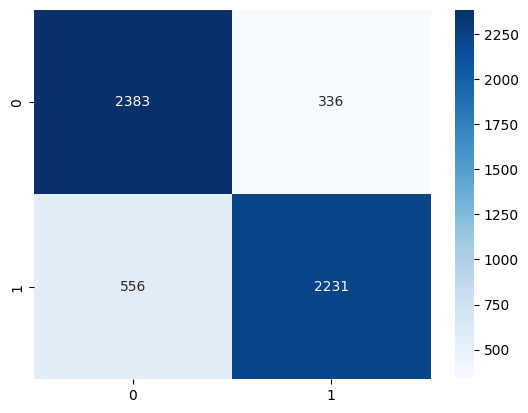

In [26]:
sns.heatmap(cm_knn, annot=True, cmap='Blues', fmt='g')

In [1]:
pip install imbalanced-learn


     -------------------------------------- 226.0/226.0 kB 1.4 MB/s eta 0:00:00


In [27]:
import numpy as np
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.combine import SMOTEENN

smote_enn = SMOTEENN()
adasyn = ADASYN()
smote = SMOTE()

X_augmented, y_augmented = smote_enn.fit_resample(X, y)
# Concatenate X_augmented with X
X_augmented = np.concatenate((X, X_augmented), axis=0)

# Concatenate y_augmented with y
y_augmented = np.concatenate((y, y_augmented), axis=0)


# Print the shapes of augmented 'X' and 'y'
print("Original X shape:", X.shape)
print("Original y shape:", y.shape)
print("Augmented X shape:", X_augmented.shape)
print("Augmented y shape:", y_augmented.shape)

Original X shape: (16684, 13)
Original y shape: (16684,)
Augmented X shape: (26899, 13)
Augmented y shape: (26899,)
